In [ ]:
pip install transformers
pip install snscrape
pip install cryptocmd

In [ ]:
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import datetime

In [ ]:
# tweets_df = pd.read_csv('/content/doge_2022-01-01_2022-12-31.csv')

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# find prediction
def prediction(text):
  if text
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return scores[0],scores[1],scores[2]

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tweets_df['Sentiment'] = tweets_df['Tweet'].apply(prediction)
tweets_df[['Negative','Neutral','Positive']] = pd.DataFrame(tweets_df['Sentiment'].tolist(), index=tweets_df.index)

In [ ]:
# replacing na values in college with No college
tweets_df["Tweet"].fillna("", inplace = True)

In [ ]:
tweets_df["Tweet"].info()

In [ ]:
# tweets_df.to_csv('doge_2022_with_sentiments.csv') 

In [ ]:
agg_df = tweets_df.groupby(['Date'])[['Negative','Positive','Neutral']].mean()

In [ ]:
from cryptocmd import CmcScraper

# initialise scraper with time interval
scraper = CmcScraper("DOGE", "01-01-2022", "31-12-2022")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
json_data = scraper.get_data("json")

# export the data to csv
scraper.export("csv")

# get dataframe for the data
price_df = scraper.get_dataframe()

In [ ]:
agg_df = agg_df.reset_index()

In [ ]:
agg_df['Date'] = pd.to_datetime(agg_df.Date)

In [ ]:
agg_df['Date']

0     2022-01-01
1     2022-01-02
2     2022-01-03
3     2022-01-04
4     2022-01-05
         ...    
359   2022-12-26
360   2022-12-27
361   2022-12-28
362   2022-12-29
363   2022-12-30
Name: Date, Length: 364, dtype: datetime64[ns]

In [ ]:
price_df['Date']

0     2022-12-31
1     2022-12-30
2     2022-12-29
3     2022-12-28
4     2022-12-27
         ...    
360   2022-01-05
361   2022-01-04
362   2022-01-03
363   2022-01-02
364   2022-01-01
Name: Date, Length: 365, dtype: datetime64[ns]

In [ ]:
final_df = price_df.merge(agg_df,on='Date')

In [ ]:
# final_df = final_df[['Date', 'Open', 'High', 'Low','Volume', 'likecount', 'Negative', 'Positive', 'Neutral','Close']]
# final_df = final_df[['Date','likecount', 'Negative', 'Positive', 'Neutral','Close']]
final_df = final_df[['Date','Volume','Market Cap', 'Negative', 'Positive', 'Neutral','Close']]

In [ ]:
final_df= final_df.sort_values('Date')

In [ ]:
final_df = final_df.set_index('Date')

In [ ]:
# final_df.to_csv('forecast2021_1.csv')

In [ ]:
train_df = final_df[['Open', 'High', 'Low', 'Close', 'likecount', 'Negative', 'Positive', 'Neutral']]

In [ ]:
final_df.head()

,Volume,Market Cap,Negative,Positive,Neutral,Close
Date,,,,,,
2022-01-01,3.713361e+08,2.295674e+10,0.070178,0.605517,0.324304,0.173035
2022-01-02,3.910419e+08,2.313818e+10,0.067008,0.616461,0.316531,0.174403
2022-01-03,5.059004e+08,2.256573e+10,0.077161,0.457693,0.465146,0.170088
2022-01-04,5.419229e+08,2.239516e+10,0.088715,0.475401,0.435884,0.168803
2022-01-05,9.940868e+08,2.115041e+10,0.028029,0.610347,0.361624,0.159420


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df[['Volume','Market Cap','Negative', 'Positive', 'Neutral','Close']], final_df['Close'], test_size=0.30, shuffle=False)

In [ ]:
len(X_train) + len(X_test)

364

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MultivariateDataset(Dataset):
    def __init__(self, data, seq_length):
        self.seq_length = seq_length
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_length][:-1], self.data[idx+self.seq_length][-1]

class MultivariateTestDataset(Dataset):
    def __init__(self, data, seq_length):
        self.seq_length = seq_length
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        return self.data[idx+self.seq_length][1:3]

class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultivariateLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data
sc = MinMaxScaler()
# Convert the DataFrame to a list
df_list = X_train.values.tolist()
# y_list = y_train.values.tolist()
data = sc.fit_transform(df_list)
test_list = X_test.values.tolist()
# testy_list = y_test.values.tolist()
data = sc.fit_transform(df_list)
test_data = sc.transform(test_list)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
Close_list = final_df['Close'].values.reshape(-1,1)
Close_scaled = scaler_pred.fit_transform(Close_list)

# data = df_list
seq_length = 7
batch_size = 1
train_set = MultivariateDataset(data,seq_length)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

#test_data
test_set = MultivariateDataset(test_data,seq_length)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize model
input_dim = len(data[0])
hidden_dim = 100
output_dim = 1
lstm_model = MultivariateLSTM(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train model
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/100 - Loss: 0.0274
Epoch 2/100 - Loss: 0.0209
Epoch 3/100 - Loss: 0.0199
Epoch 4/100 - Loss: 0.0177
Epoch 5/100 - Loss: 0.0163
Epoch 6/100 - Loss: 0.0146
Epoch 7/100 - Loss: 0.0132
Epoch 8/100 - Loss: 0.0119
Epoch 9/100 - Loss: 0.0107
Epoch 10/100 - Loss: 0.0098
Epoch 11/100 - Loss: 0.0088
Epoch 12/100 - Loss: 0.0082
Epoch 13/100 - Loss: 0.0075
Epoch 14/100 - Loss: 0.0071
Epoch 15/100 - Loss: 0.0067
Epoch 16/100 - Loss: 0.0064
Epoch 17/100 - Loss: 0.0061
Epoch 18/100 - Loss: 0.0059
Epoch 19/100 - Loss: 0.0057
Epoch 20/100 - Loss: 0.0055
Epoch 21/100 - Loss: 0.0054
Epoch 22/100 - Loss: 0.0052
Epoch 23/100 - Loss: 0.0051
Epoch 24/100 - Loss: 0.0050
Epoch 25/100 - Loss: 0.0049
Epoch 26/100 - Loss: 0.0048
Epoch 27/100 - Loss: 0.0047
Epoch 28/100 - Loss: 0.0046
Epoch 29/100 - Loss: 0.0046
Epoch 30/100 - Loss: 0.0045
Epoch 31/100 - Loss: 0.0044
Epoch 32/100 - Loss: 0.0044
Epoch 33/100 - Loss: 0.0044
Epoch 34/100 - Loss: 0.0043
Epoch 35/100 - Loss: 0.0043
Epoch 36/100 - Loss: 0.0042
E

In [ ]:
res = []
for i, (inputs, targets) in enumerate(test_loader):
    # Get future predictions
    lstm_model.eval()
    with torch.no_grad():
        predicted_output = lstm_model(inputs.to(device))

    res.append(scaler_pred.inverse_transform(predicted_output)[0][0])

In [ ]:
res_train = []
for i, (inputs, targets) in enumerate(train_loader):
    # Get train historical predictions
    lstm_model.eval()
    with torch.no_grad():
        predicted_train_output = lstm_model(inputs.to(device))
    res_train.append(scaler_pred.inverse_transform(predicted_train_output)[0][0])
     

In [ ]:
new_res_train = [0.18,0.18,0.18,0.18,0.18,0.18,0.18]
new_res = [0.06,0.06,0.06,0.06,0.06,0.06,0.06]

In [ ]:
# adding first 7 days missing data
for i in res:
  new_res.append(i)

In [ ]:
# adding first 7 days missing data
for i in res_train:
  new_res_train.append(i)

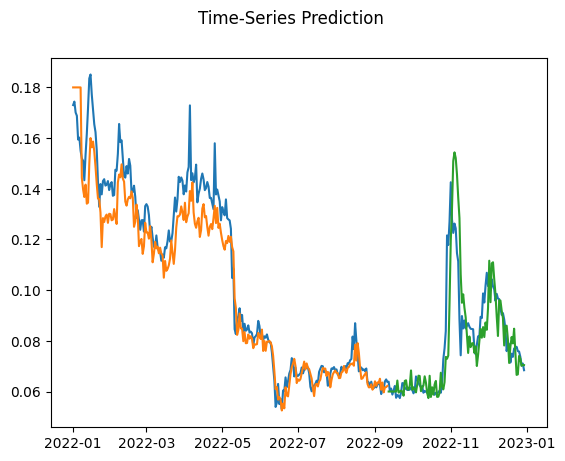

In [ ]:
plt.plot(agg_df['Date'],Close_list)
plt.plot(agg_df['Date'][:len(new_res_train)],new_res_train)
plt.plot(agg_df['Date'][len(new_res_train):],new_res)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
forecast_df = final_df.reset_index()[['Date','Close']]

In [ ]:
forecast_df

,Date,Close
0,2022-01-01,0.173035
1,2022-01-02,0.174403
2,2022-01-03,0.170088
3,2022-01-04,0.168803
4,2022-01-05,0.159420
...,...,...
359,2022-12-26,0.075783
360,2022-12-27,0.073724
361,2022-12-28,0.070381
362,2022-12-29,0.071042


In [ ]:
final_results_train=new_res_train + [None]*110

In [ ]:
final_results_test=[None]*254 + new_res

In [ ]:
forecast_df['Results_train'] = final_results_train

In [ ]:
forecast_df['Results_test'] = final_results_test

In [ ]:
forecast_df.drop(columns=['Results'],inplace=True,axis=1)

In [ ]:
forecast_df

,Date,Close,Results_train,Results_test
0,2022-01-01,0.173035,0.18,NaN
1,2022-01-02,0.174403,0.18,NaN
2,2022-01-03,0.170088,0.18,NaN
3,2022-01-04,0.168803,0.18,NaN
4,2022-01-05,0.159420,0.18,NaN
...,...,...,...,...
359,2022-12-26,0.075783,NaN,0.074040
360,2022-12-27,0.073724,NaN,0.072957
361,2022-12-28,0.070381,NaN,0.070109
362,2022-12-29,0.071042,NaN,0.070505


In [ ]:
forecast_df.to_csv('forecast2022_split.csv')

In [17]:
# MSE in test data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

f1 = pd.read_csv('/content/forecast2020_split.csv')
f2 = pd.read_csv('/content/forecast2021_split.csv')
f3 = pd.read_csv('/content/forecast2022_split.csv')

In [12]:
f1.head()

,Unnamed: 0,Date,Close,Results_train,Results_test
0,0,2020-01-01,0.002033,0.002,NaN
1,1,2020-01-03,0.002145,0.002,NaN
2,2,2020-01-04,0.002241,0.002,NaN
3,3,2020-01-05,0.002419,0.002,NaN
4,4,2020-01-06,0.002463,0.002,NaN


In [ ]:
f1['Results_test'][237:]

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

# Calculation of Mean Squared Error (MSE)

print('MSE 2020:',mean_squared_error(f1['Close'][237:],f1['Results_test'][237:]))
print('MAE 2020:',mae(f1['Close'][237:],f1['Results_test'][237:]))

MSE 2020: 1.0779288777917702e-07
MAE 2020: 0.00026554658283036564


In [72]:

print('MSE 2021:',mean_squared_error(f2['Close'][252:],f2['Results_test'][252:]))
print('MAE 2021:',mae(f2['Close'][252:],f2['Results_test'][252:]))

MSE 2021: 0.0006844602525335133
MAE 2021: 0.020789634938512797


In [77]:

print('MSE 2022:',mean_squared_error(f3['Close'][254:],f3['Results_test'][254:]))
print('MAE 2022:',mae(f3['Close'][254:],f3['Results_test'][254:]))

MSE 2022: 0.00015001942092505654
MAE 2022: 0.00760051427710969
